# Analyze the performance of the best model
Considering that the logistic regression outperformed the other models, and the version with the network feature generalize better with respect to the one-hot encoding one, we take it as best model (logistic regression with network feature).

In [408]:
import joblib as jl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
)
from sklearn.preprocessing import maxabs_scale

## Load model and Dataset

In [409]:
# Load the models
modelPath = "../models/log_reg_mix.joblib"
model = jl.load(modelPath)

dataPath = "../features/LR_mix_full_data.npz"
data = np.load(dataPath)


# Load the data
path = "../features/"
data_names = ["symptoms", "betweenness", "community_count", "community_size"]

symptoms = np.load(path + data_names[0] + ".npz")
betweenness = np.load(path + data_names[1] + ".npz")
community_count = np.load(path + data_names[2] + ".npz")
community_size = np.load(path + data_names[3] + ".npz")
data_mix = np.concatenate(
    (
        betweenness["X"],
        community_count["X"],
        community_size["X"],
        community_count["y"].reshape(symptoms["y"].shape[0], 1),
    ),
    axis=1,
)

data_norm = maxabs_scale(data_mix[:, :-1])
data = np.concatenate(
    (data_norm, data_mix[:, -1].reshape(data_mix[:, -1].shape[0], 1)), axis=1
)

x = data[:, :-1]
y = data[:, -1].astype(int)

In [410]:
print(y.min())
print(y.max())
print(len(y))
print(len(np.unique(y)))

0
772
246914
748


## Create a 'Mapping' dataframe

In [411]:
diseases_info = pd.read_csv("../../../dataset/diseases_complete_info.csv")
all_diseases = pd.read_csv("../../../dataset/disease_label_mapping.csv")

y_df = pd.DataFrame(y, columns=["Disease_num"])

tmp = pd.merge(y_df, all_diseases, on="Disease_num", how="left")
print(len(tmp["Disease"].unique()))


complete_df = pd.merge(tmp, diseases_info, on="Disease", how="left")
print(len(complete_df["Disease"].unique()))
complete_df = complete_df[["Disease", "Disease_num", "Class"]]


class_mapping = pd.Series(
    complete_df["Class"].values, index=complete_df["Disease_num"]
).to_dict()
name_mapping = pd.Series(
    complete_df["Class"].values, index=complete_df["Disease"]
).to_dict()

complete_df

748
748


,Disease,Disease_num,Class
0,crushing injury,512,3.0
1,crushing injury,512,3.0
2,crushing injury,512,3.0
3,crushing injury,512,3.0
4,crushing injury,512,3.0
...,...,...,...
246909,bursitis,677,1.0
246910,bursitis,677,1.0
246911,bursitis,677,1.0
246912,bursitis,677,1.0


## Map the classes and pedictions

In [412]:
disease_num_series = pd.Series(y)
y_class = disease_num_series.map(class_mapping).values

y_class[np.isnan(y_class)] = 1 # type: ignore


pred = model.predict(x)
disease_num_series = pd.Series(pred)
pred_class = disease_num_series.map(class_mapping).values
pred_class[np.isnan(pred_class)] = 1 # type: ignore

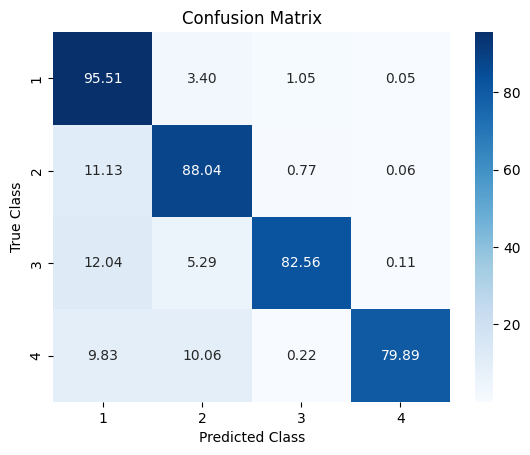

In [413]:
conf_matrix_class = confusion_matrix(y_class, pred_class)  # type: ignore

conf_matrix_class_percent = (
    conf_matrix_class / np.sum(conf_matrix_class, axis=1, keepdims=True) * 100
)

# Plot the confusion matrix with percentages
sns.heatmap(
    conf_matrix_class_percent,
    annot=True,
    fmt=".2f",  # Format as percentage with two decimal places
    cmap="Blues",
    cbar=True,
    xticklabels=np.unique(y_class).astype(int),  # type: ignore
    yticklabels=np.unique(y_class).astype(int),  # type: ignore
)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()

## Get accuracy for each class

In [414]:
conf_matrix = confusion_matrix(y, pred)
conf_matrix_percent = conf_matrix / np.sum(conf_matrix, axis=1, keepdims=True)


accuracies = [conf_matrix_percent[i, i] for i in range(len(conf_matrix_percent))]

accuracies_df = pd.DataFrame({"Disease_num": np.unique(y), "Accuracy": accuracies})

## It's impossible to visualize the whole confusion matrix, so we try a different approach

,Disease_num,Disease,precision,recall,f1-score,Accuracy
0,0,fracture of the pelvis,0.825145,0.842183,0.833577,0.842183
1,1,testicular cancer,0.857143,1.000000,0.923077,1.000000
2,2,injury to the arm,0.938998,0.966368,0.952486,0.966368
3,3,heat stroke,0.724138,0.965517,0.827586,0.965517
4,4,sporotrichosis,0.200000,1.000000,0.333333,1.000000
...,...,...,...,...,...,...
743,768,induced abortion,0.995356,0.941435,0.967645,0.941435
744,769,pelvic inflammatory disease,0.897281,0.889222,0.893233,0.889222
745,770,thyroid nodule,0.806452,0.937500,0.867052,0.937500
746,771,diverticulitis,0.307692,0.800000,0.444444,0.800000


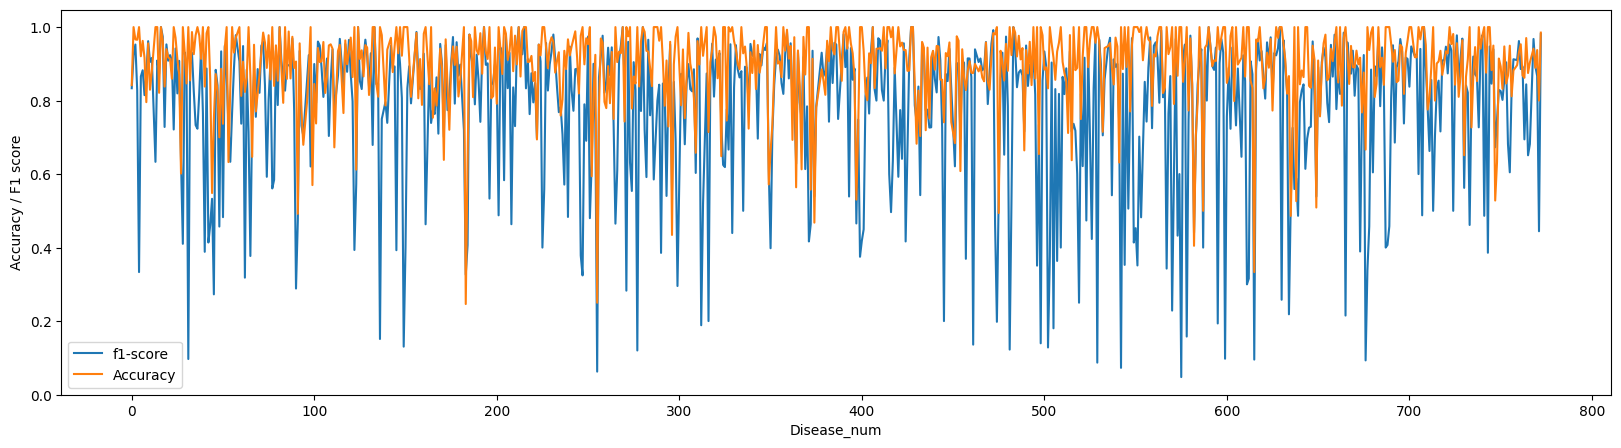

In [415]:
all_diseases = pd.read_csv("../../../dataset/disease_label_mapping.csv")

report = classification_report(y, pred, output_dict=True)

report_df = pd.DataFrame(report)
report_df = report_df.drop(columns=["accuracy", "macro avg", "weighted avg"])


report_df = report_df.transpose()
report_df["Disease_num"] = report_df.index

report_df = report_df.sort_values(by="f1-score", ascending=False)
report_df = report_df.reset_index()


# Convert 'Disease_num' column in complete_df to int64
report_df["Disease_num"] = report_df["Disease_num"].astype(int)


report_df = pd.merge(report_df, complete_df, on="Disease_num")
report_df = pd.merge(report_df, accuracies_df, on="Disease_num")

report_df = report_df.drop(columns=["index", "support", "Class"])
report_df = report_df.groupby(["Disease_num", "Disease"]).mean()
report_df = report_df.reset_index()
report_df.plot(
    kind="line", x="Disease_num", y=["f1-score","Accuracy"],ylabel="Accuracy / F1 score", figsize=(20, 5))
report_df

## Get diseases with the highest accuracy

In [416]:
report_df=report_df.sort_values(by="Accuracy", ascending=False)
best_diseases=report_df[['Disease_num','Disease','Accuracy','f1-score']].head(10)
best_diseases.sort_values(by="f1-score", ascending=False)

,Disease_num,Disease,Accuracy,f1-score
368,383,intertrigo (skin condition),1.0,0.955017
371,386,subconjunctival hemorrhage,1.0,0.952381
1,1,testicular cancer,1.0,0.923077
375,391,idiopathic infrequent menstruation,1.0,0.891089
82,84,syphilis,1.0,0.827004
372,387,systemic lupus erythematosis (sle),1.0,0.750000
377,393,rheumatic fever,1.0,0.539007
384,400,arrhythmia,1.0,0.418605
358,371,foreign body in the ear,1.0,0.416667
383,399,poisoning due to antihypertensives,1.0,0.375000


## Get the diseases with the lowest accuracy

In [417]:
worst_diseases = report_df[["Disease_num", "Disease", "Accuracy", "f1-score"]].tail(10)
worst_diseases

,Disease_num,Disease,Accuracy,f1-score
567,587,premature ventricular contractions (pvcs),0.500000,0.400000
456,475,fracture of the jaw,0.494083,0.547541
89,91,hemiplegia,0.491954,0.473976
613,635,omphalitis,0.486279,0.523641
361,374,poisoning due to antimicrobial drugs,0.467849,0.539642
285,296,open wound of the mouth,0.434379,0.556134
562,582,acute otitis media,0.404840,0.440455
593,615,blepharitis,0.333333,0.095238
245,255,otitis media,0.250000,0.062500
173,183,bladder cancer,0.246377,0.326199


### Get the diseases mispredicted as 'bladder cancer'

173


<Axes: title={'center': 'Bladder cancer missclassified samples'}, xlabel='Disease', ylabel='Percentage of missclassified samples'>

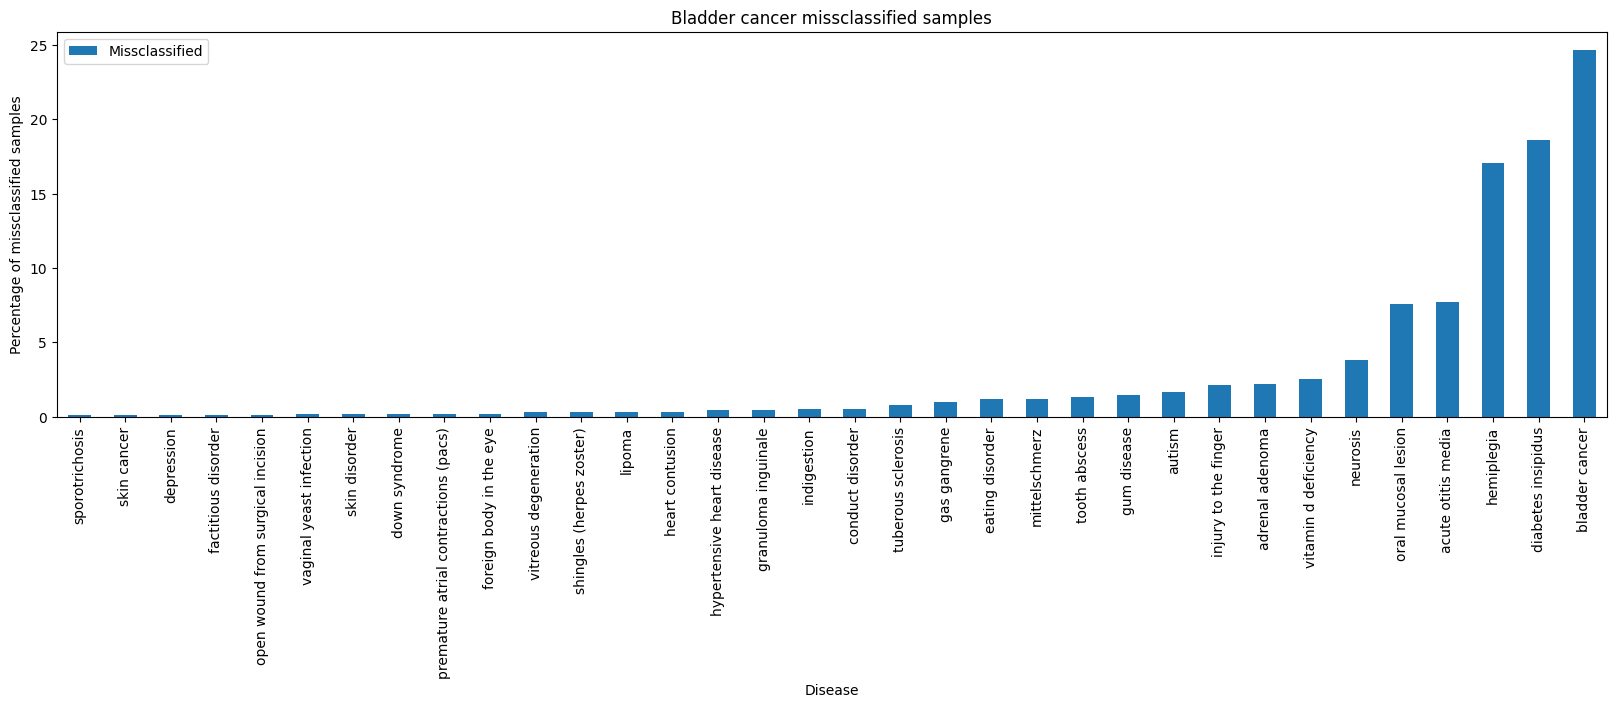

In [418]:
order = np.array(np.unique(y))
pos_conf_matrix_bc = np.where(
    order
    == worst_diseases[worst_diseases["Disease"] == "bladder cancer"][
        "Disease_num"
    ].values[0]
)[0][0]

missclassified = conf_matrix_percent[pos_conf_matrix_bc, :]

bladder_cancer_df = pd.DataFrame(
    {"Disease_num": order, "Missclassified": missclassified}
)
bladder_cancer_df = pd.merge(bladder_cancer_df, complete_df, on="Disease_num")
bladder_cancer_df = bladder_cancer_df[bladder_cancer_df["Missclassified"] > 0]
print(pos_conf_matrix_bc)
bladder_cancer_df = (
    bladder_cancer_df[["Disease", "Missclassified"]].groupby("Disease").mean()
)
bladder_cancer_df["Missclassified"] = bladder_cancer_df["Missclassified"] * 100
bladder_cancer_df.sort_values(by="Missclassified", ascending=True).plot(
    kind="bar",
    figsize=(20, 5),
    ylabel="Percentage of missclassified samples",
    title="Bladder cancer missclassified samples",
    xlabel="Disease",
)

### Get the diseases mispredicted as 'otitis media'

245


<Axes: title={'center': 'Otitis media missclassified samples'}, xlabel='Disease', ylabel='Percentage of missclassified samples'>

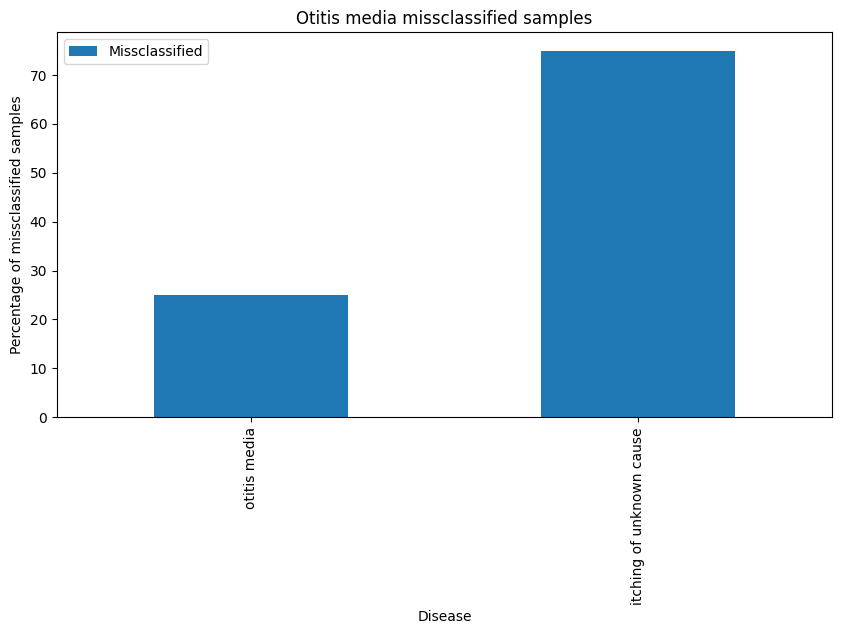

In [419]:
order = np.array(np.unique(y))
pos_conf_matrix_om = np.where(
    order
    == worst_diseases[worst_diseases["Disease"] == "otitis media"][
        "Disease_num"
    ].values[0]
)[0][0]

missclassified = conf_matrix_percent[pos_conf_matrix_om, :]

otitis_media_df = pd.DataFrame(
    {"Disease_num": order, "Missclassified": missclassified}
)
otitis_media_df = pd.merge(otitis_media_df, complete_df, on="Disease_num")
otitis_media_df = otitis_media_df[otitis_media_df["Missclassified"] > 0]
print(pos_conf_matrix_om)
otitis_media_df = (
    otitis_media_df[["Disease", "Missclassified"]].groupby("Disease").mean()
)
otitis_media_df["Missclassified"] = otitis_media_df["Missclassified"] * 100
otitis_media_df.sort_values(by="Missclassified", ascending=True).plot(
    kind="bar",
    figsize=(10, 5),
    ylabel="Percentage of missclassified samples",
    title="Otitis media missclassified samples",
    xlabel="Disease",
)

## Try to explain the mispredictions

### 1- They have the less number of samples 

In [420]:
bladder_cancer_num = worst_diseases[worst_diseases["Disease"] == "bladder cancer"][
    "Disease_num"
].values[0]

otitis_media_num = worst_diseases[worst_diseases["Disease"] == "otitis media"][
    "Disease_num"
].values[0]

bladder_cancer_count = np.count_nonzero(y == bladder_cancer_num)
otitis_media_count = np.count_nonzero(y == otitis_media_num)

print("Percentage of sample of bladder cancer : ",bladder_cancer_count/len(y)*100)
print("Percentage of sample of otitis media : ",otitis_media_count/len(y)*100)


Percentage of sample of bladder cancer :  0.3632843824165499
Percentage of sample of otitis media :  0.0016199972460046817


### 2- They have similar symptoms

#### 2.1- Bladder cancer, diabetes insipidus and hemiplegia

In [421]:
symptoms = pd.read_csv("../../../dataset/symptoms.csv")
one_hot_encoding = pd.read_csv(
    "../../../dataset/large_one_hot_encoding.csv", compression="gzip"
)
diabetes_insipidus_num = report_df[report_df["Disease"] == "diabetes insipidus"][
    "Disease_num"
].values[0]

hemiplegia_num = report_df[report_df["Disease"] == "hemiplegia"]["Disease_num"].values[
    0
]

bladder_cancer_symptoms = one_hot_encoding[one_hot_encoding["Disease"] == bladder_cancer_num]
bladder_cancer_symptoms = bladder_cancer_symptoms.groupby("Disease").sum()
bladder_cancer_symptoms = bladder_cancer_symptoms.reset_index()
bladder_cancer_symptoms = bladder_cancer_symptoms.drop(columns=["Unnamed: 0"])
bladder_cancer_symptoms = bladder_cancer_symptoms.transpose()
bladder_cancer_symptoms = bladder_cancer_symptoms.reset_index()
bladder_cancer_symptoms = bladder_cancer_symptoms.rename(
    columns={bladder_cancer_symptoms.columns[0]: "Symptom"}
)
bladder_cancer_symptoms = bladder_cancer_symptoms.drop(bladder_cancer_symptoms.index[0])

bladder_cancer_symptoms = bladder_cancer_symptoms[bladder_cancer_symptoms[0] != 0]
print("Bladder cancer symptoms :", bladder_cancer_symptoms["Symptom"].tolist())

diabets_symptoms = one_hot_encoding[
    one_hot_encoding["Disease"] == diabetes_insipidus_num
]
diabets_symptoms = diabets_symptoms.groupby("Disease").sum()
diabets_symptoms = diabets_symptoms.reset_index()
diabets_symptoms = diabets_symptoms.drop(columns=["Unnamed: 0"])
diabets_symptoms = diabets_symptoms.transpose()
diabets_symptoms = diabets_symptoms.reset_index()
diabets_symptoms = diabets_symptoms.rename(
    columns={diabets_symptoms.columns[0]: "Symptom"}
)
diabets_symptoms = diabets_symptoms.drop(diabets_symptoms.index[0])

diabets_symptoms = diabets_symptoms[diabets_symptoms[0] != 0]
print("Diabets insipidus symptoms :", diabets_symptoms["Symptom"].tolist())


hemiplegia_symptoms = one_hot_encoding[one_hot_encoding["Disease"] == hemiplegia_num]
hemiplegia_symptoms = hemiplegia_symptoms.groupby("Disease").sum()
hemiplegia_symptoms = hemiplegia_symptoms.reset_index()
hemiplegia_symptoms = hemiplegia_symptoms.drop(columns=["Unnamed: 0"])
hemiplegia_symptoms = hemiplegia_symptoms.transpose()
hemiplegia_symptoms = hemiplegia_symptoms.reset_index()
hemiplegia_symptoms = hemiplegia_symptoms.rename(
    columns={hemiplegia_symptoms.columns[0]: "Symptom"}
)
hemiplegia_symptoms = hemiplegia_symptoms.drop(hemiplegia_symptoms.index[0])

hemiplegia_symptoms = hemiplegia_symptoms[hemiplegia_symptoms[0] != 0]
print("Hemiplegia symptoms :", hemiplegia_symptoms["Symptom"].tolist())

Bladder cancer symptoms : ['retention of urine', 'groin mass', 'mass in scrotum', 'blood in urine', 'excessive urination at night', 'symptoms of bladder', 'bladder mass']
Diabets insipidus symptoms : ['dizziness', 'emotional symptoms']
Hemiplegia symptoms : ['abnormal involuntary movements', 'difficulty speaking', 'headache', 'arm stiffness or tightness', 'problems with movement', 'weakness', 'loss of sensation', 'slurring words', 'seizures']


### Deep Analysis Cancer vs Diabetis

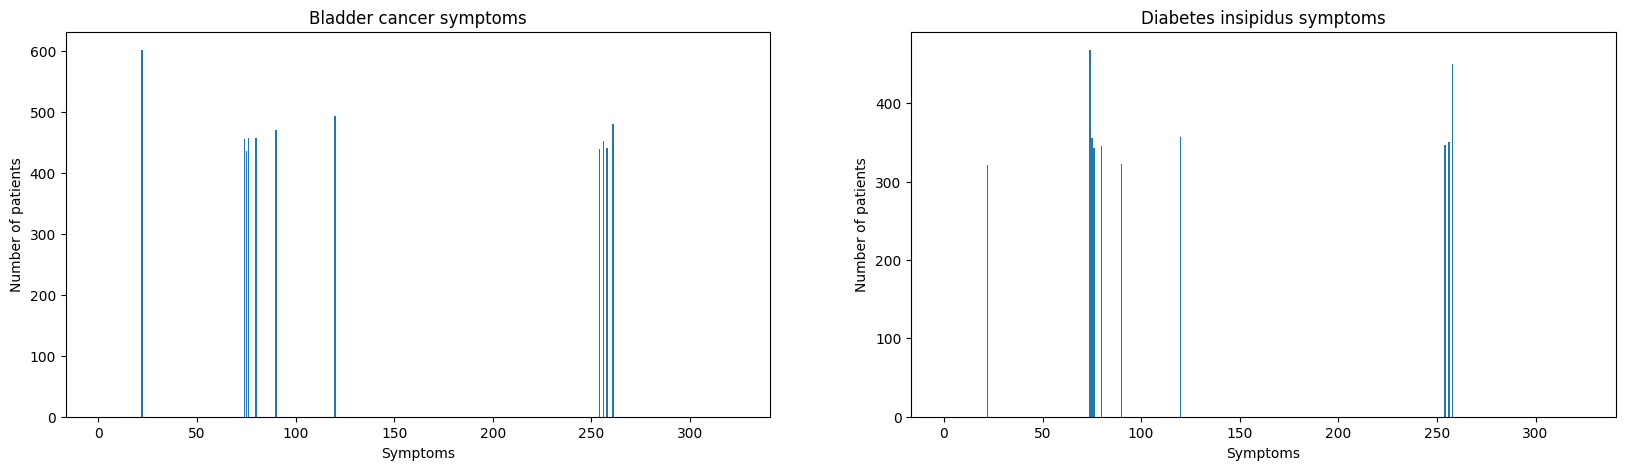

In [431]:
symptoms = np.load(path + data_names[0] + ".npz")

# Take the symptoms of 'bladder cancer' and 'diabetes insipidus' and plot them
bladder_cancer = complete_df[complete_df["Disease"] == "bladder cancer"]
bladder_cancer = bladder_cancer["Disease_num"].values[0]

insipidus = complete_df[complete_df["Disease"] == "diabetes insipidus"]
insipidus = insipidus["Disease_num"].values[0]

bladder_cancer_symptoms = symptoms["X"][y == bladder_cancer]
insipidus_symptoms = symptoms["X"][y == insipidus]

bladder_cancer_symptoms = np.sum(bladder_cancer_symptoms, axis=0)
insipidus_symptoms = np.sum(insipidus_symptoms, axis=0)

# plot

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.bar(np.arange(len(bladder_cancer_symptoms)), bladder_cancer_symptoms)
plt.title("Bladder cancer symptoms")
plt.ylabel("Number of patients")
plt.xlabel("Symptoms")
plt.subplot(1, 2, 2)
plt.bar(np.arange(len(insipidus_symptoms)), insipidus_symptoms)
plt.title("Diabetes insipidus symptoms")
plt.ylabel("Number of patients")
plt.xlabel("Symptoms")
plt.show()

In [432]:
# get the symptoms in common between the two diseases
common_symptoms = np.logical_and(bladder_cancer_symptoms, insipidus_symptoms)
common_symptoms = np.where(common_symptoms == True)[0]

# compute the ratio of symptoms which are shared between the two diseases
num_symptoms_cancer = np.count_nonzero(bladder_cancer_symptoms)
num_symptoms_insipidus = np.count_nonzero(insipidus_symptoms)
num_common_symptoms = len(common_symptoms)

ratio_cancer = num_common_symptoms / num_symptoms_cancer
ratio_insipidus = num_common_symptoms / num_symptoms_insipidus

print("Ratio of common symptoms for bladder cancer: ", ratio_cancer)
print("Ratio of common symptoms for diabetes insipidus: ", ratio_insipidus)



Ratio of common symptoms for bladder cancer:  0.9090909090909091
Ratio of common symptoms for diabetes insipidus:  1.0


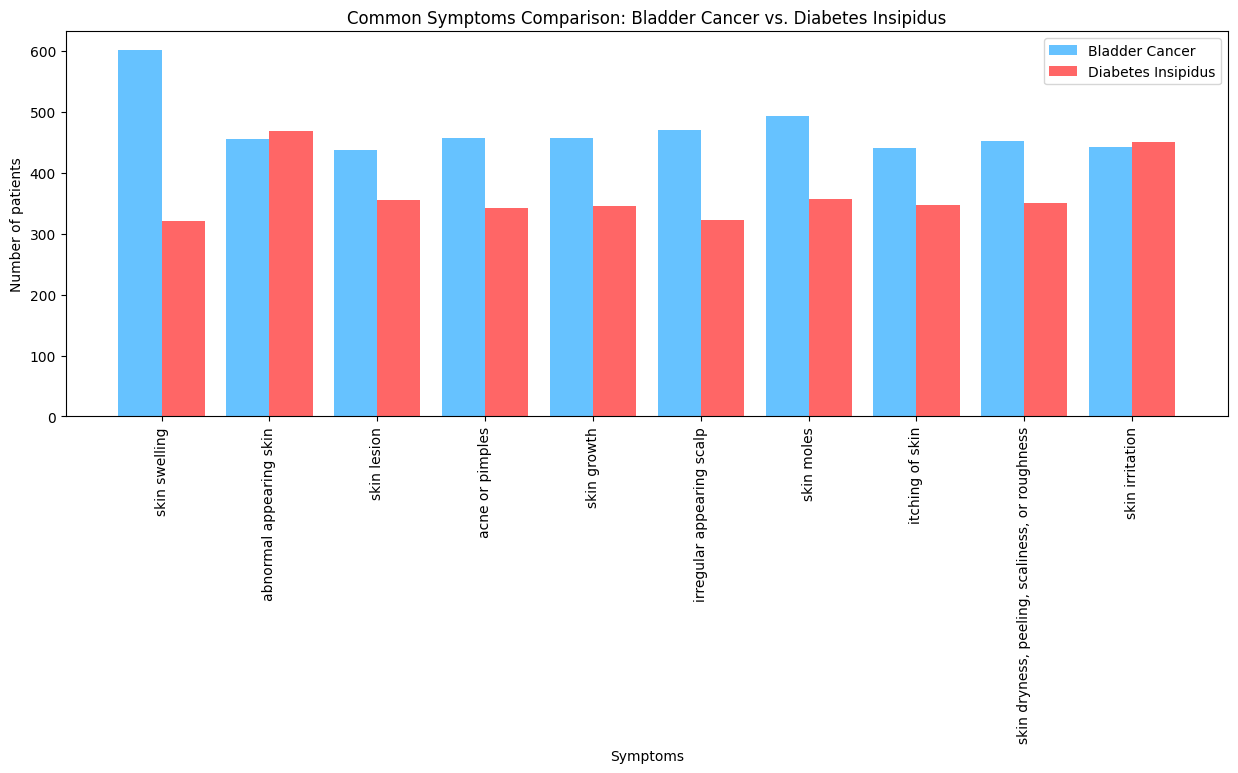

In [437]:
# Get symptoms names
names = pd.read_csv('../../../dataset/symptoms.csv').values[:,0]
names[:][common_symptoms]

# plot the number of patients for these symptoms for each disease
# Use the same barplot with two bars for each symptom

bladder_cancer_symptoms = bladder_cancer_symptoms[common_symptoms]
insipidus_symptoms = insipidus_symptoms[common_symptoms]

# Set the width of the bars
bar_width = 0.4

# Create positions for the bars
positions1 = np.arange(len(bladder_cancer_symptoms))
positions2 = positions1 + bar_width

# Plot the bar chart
plt.figure(figsize=(15, 5))

plt.bar(positions1, bladder_cancer_symptoms, width=bar_width, label='Bladder Cancer', color='#66c2ff')
plt.bar(positions2, insipidus_symptoms, width=bar_width, label='Diabetes Insipidus', color='#ff6666')

plt.title("Common Symptoms Comparison: Bladder Cancer vs. Diabetes Insipidus")
plt.ylabel("Number of patients")
plt.xlabel("Symptoms")
plt.xticks((positions1 + positions2) / 2, names[common_symptoms], rotation=90)
plt.legend()

plt.show()